In [ ]:
#!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import csv
import matplotlib.pyplot as plt
# Will use the HugginFace implementation of BERT
# Using pytorch as DL framework
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader # For preprocessing of data and prepping it
# Place to explore
# https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/notebooks

# For preprocessing the text (cleaning time)
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import STOPWORDS,WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
PRE_TRAINED_MODEL = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL) # for making text compatible with BERT

In [ ]:
# I will need to drop the id column when training

x_train_full = pd.read_csv('/content/drive/My Drive/AAA - DC2/train.csv',infer_datetime_format=True )[['id','title','text','date','is_fake']]
x_test_full = pd.read_csv('/content/drive/My Drive/AAA - DC2/test.csv',infer_datetime_format=True)[['id','title','text','date']]

In [ ]:
x_train_full.isnull().sum()

id         0
title      0
text       0
date       0
is_fake    0
dtype: int64

### Feature engineering as needed

### Data preparation, cleaning, and handling for torch batching


In [ ]:
x_train_full.head()

,id,title,text,date,is_fake,len_text,len_title
0,0,BREAKING: Wikileaks Releases Vault 7 Part 1 Y...,21st Century Wire says WikiLeaks has released ...,726187,1,4082,9
1,1,UK PM May confident parliament will have vote ...,British Prime Minister Theresa May said on Wed...,726415,0,50,12
2,2,U.S. Spy Chief James Clapper: U.S. Must Be Pre...,"Well, get busy people! With the cyber attacks ...",725650,1,35,15
3,3,Trump will announce new U.S. security strategy...,U.S. President Donald Trump will announce a ne...,726462,0,80,10
4,4,Trump says to approve lifting restrictions on ...,U.S. President Donald Trump gave his in princ...,726364,0,93,12


In [ ]:
def string_html(text):
    soup=BeautifulSoup(text,"html.parser")
    return soup.get_text()

def remove_square_brackets(text):
    return re.sub('\[[^]]*\]','',text)

def remove_URL(text):
    return re.sub(r'http\S+','',text)

def remove_stopwords(text):
    final_text=[]
    for i in text.split():
        if i.strip().lower() not in stop_words: # global variable
            final_text.append(i.strip())
    return " ".join(final_text)


def clean_text_data(text):
  '''
  Take DataFrame and clean the data before training.
  1. remove HTML
  2. remove square breaackets.
  3. remove stipwords
  4. remove URL
  '''

  text = string_html(text)
  text = remove_square_brackets(text)
  text = remove_stopwords(text)
  text = remove_URL(text)

  return text


In [ ]:
# combine text and title
x_train_full['text'] = x_train_full['title'] + " " + x_train_full['text']

# Prepare stopwords
stop_words=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop_words.update(punctuation)

In [ ]:
# clean text
x_train_full['text'] = x_train_full['text'].apply(lambda x: clean_text_data(x))

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val  = train_test_split(x_train_full, test_size=0.05, random_state=0) # 90% of data is for training

NewsDataset is the class which is used to prepare the training and validation sets of data to be fed to my PyTorch model. Creating these classes is a common practice when doing batch training with PyTorch.

In [ ]:
class NewsDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    #selt.title = titles  # Will implement this later
    #self.dates = dates # Will implement this later
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts) # number text passages

  def __getitem__(self, item):
    text = str(self.texts[item])
    #text = str(self.titles[item])
    #date = self.dates[item]
    label = self.labels[item]

    # Combine encoding of text and title before sending to encore in future here

    encoding = self.tokenizer.encode_plus(
                text, 
                add_special_tokens = True,
                max_length = self.max_len,
                return_token_type_ids = False, 
                padding = 'max_length', # True, 'longest','max_length'
                return_attention_mask = True,
                return_tensors = 'pt',
                truncation = True
    )

    return {
          'text':text,
          #'title',title
          # 'date':date
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label,dtype=torch.long)

    }

create_data_loader is a function which builds batches of data this calls NewsDataset inside of it.

In [ ]:
def create_data_loader(data, tokenizer, max_len, batch_size):
  ds = NewsDataset(
      texts = data['text'].to_numpy(),
      labels = data['is_fake'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4,
  )

Creating training and validation set. I unfortunately do not do cross validation as it would be too computationally expensive for my resources.

In [ ]:
# Create datasets

BATCH_SIZE = 32 # Will try 32 later
MAX_LEN = 200 # setting max length of the sentences for fixsed length -> BERT

train_data_loader = create_data_loader(x_train_full, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

### Create Model: Class that the model is in

FakeNewsClassifer is my PyTorch model this like NewsDataset is a standard way of creating models in PyTorch.

My Model consists of using BertModel and taking the hidden output layer at the CLS token, apply dropout. Then I apply a linear transformation with a matrix of size (hidden output layer = 768, number of classes=2). I then use cross-entropy loss on these two outputs. First node is probability of being REAL news and the second is FAKE news (Doesn't really matter was convienent since I treat the index as the label to count accuracy).

In [ ]:
class FakeNewsClassifier(nn.Module): # AKA the BS detector

  def __init__(self, n_classes):
    super(FakeNewsClassifier,self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL) # Global input
    self.drop = nn.Dropout(p=0.3) # Used to apply dropout when necessary (if overfitting)
    
    # W transformation matrix (768,2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # Binary but doens't have to be

  def forward(self, input_ids, attention_mask): 
    # Will need to add inputs for date and len(title) eventually

    # First chunk for extracting BERT output
    # Using pooled_output for now.. later will use (_,0,_) -> CLS output
    last_hidden_state , pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    # Second chunk will be used to concatenate date and title (FUTURE)

    #output = self.drop(pooled_output)
    output = self.drop(last_hidden_state[:,0,:]) # CLS output
    #output = last_hidden_state[:,0,:] # CLS output no dropout over it for now

    return self.out(output) # output through a basic feedforward

### Create Model: train and evaluation function

Create two functions for running 1 epoch of data (going over each batch then updating parameters). One is for training and one is for evaluation. The evaluation is made for the validation set not test set.

In [ ]:
def train_epoch(model, data_loader, loss_fn,
    optimizer, device, scheduler, n_examples):
  
  model = model.train() # Set model to training mode

  losses = []   # keep log of loss
  corr_pred = 0 # Counting for accuracy

  for d in data_loader: # go over batches
    # Will need to add len(title) and date here later
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device) # 0=not_fake, 1=is_fake

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    _ , preds = torch.max(outputs, dim=1) # tensor([max_values], [indices_of_maxes])
    loss = loss_fn(outputs, targets)      # get loss to backprop on auto-diff coming up

    corr_pred += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    #nn.utils.clip_grad_norm(model.parameters(),max_norm=1.0) # protection from exploding gradient
    nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0) # protection from exploding gradient
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad() # Zero gradients for next batch

  # Return decimal of accuracy and mean loss over epoch
  return corr_pred.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  
  model = model.eval() # Set model to training mode

  losses = []   # keep log of loss
  corr_pred = 0 # Counting for accuracy

  for d in data_loader: # go over batches
    # Will need to add len(title) and date here later
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device) # 0=not_fake, 1=is_fake

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    _ , preds = torch.max(outputs, dim=1)    # tensor([max_values], [indices_of_maxes -> 0 or 1])

    loss = loss_fn(outputs, targets)         # Get loss
    corr_pred += torch.sum(preds == targets) # Somehow need to get

    losses.append(loss.item())

  # Return decimal of accuracy and mean loss over epoch
  return corr_pred.double() / n_examples, np.mean(losses)

### Training the model


Time to instantiate the model and use GPU if available (Using Google Colab is an easy way to access a GPU).

In [ ]:
## Create Model
CLASSES = 2 # BINARY FOR NOW (COULD DO STACKED ARCHITECTURE FOR THIRD CLASS OF UNSURE -> seperate model)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # Use GPU

model = FakeNewsClassifier(CLASSES)
model = model.to(device)

Setup optimizer and its parameters. Learning rate is one recommended within original BERT paper for down stream training. AdamW is a special optimizer for BERT, needs to be imported from the transformers library.

In [ ]:
# Set up training parameters

EPOCHS = 5 # number of epochs to perform

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps # maybe change this to epoches..
)

loss_fn = nn.CrossEntropyLoss().to(device)

Time to train the model.

In [ ]:
## Training loop
import timeit as tt

history = {} # for storing training history
best_accuracy = 0 # store when we got best accuracy

history['train_acc'] = []
history['train_loss'] = []
history['val_acc'] = []
history['val_loss'] = []

for epoch in range(EPOCHS):

  print("Epoch {} of {}".format(1 + epoch,EPOCHS,))
  print('----------')
  start = tt.default_timer()
  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(x_train_full)#len(df_train)
  )
  # Train loss is averaged. train accuracy is weird since first batches always worse then last.
  print('Train loss is {} and Train accuracy is {}'.format(train_loss,train_acc))
  stop = tt.default_timer()
  print('It took {} seconds to train 1 epoch.'.format(stop - start))
  
  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print('Validation loss is {} and Validation accuracy is {}'.format(val_loss, val_acc))
  print('\n')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'best_model_state.bin')
    best_accuracy = val_acc
  

Epoch 1 of 5
----------
Train loss is 0.01412041394749069 and Train accuracy is 0.9959033761830767
It took 395.890958621 seconds to train 1 epoch.
Epoch 2 of 5
----------
Train loss is 0.0014530123210635805 and Train accuracy is 0.9996892216414748
It took 396.069672673 seconds to train 1 epoch.
Epoch 3 of 5
----------
Train loss is 5.644376012263353e-06 and Train accuracy is 0.9999999999999999
It took 396.15275163499996 seconds to train 1 epoch.
Epoch 4 of 5
----------
Train loss is 3.106396166262632e-06 and Train accuracy is 0.9999999999999999
It took 396.09174815100005 seconds to train 1 epoch.
Epoch 5 of 5
----------
Train loss is 2.305130761869361e-06 and Train accuracy is 0.9999999999999999
It took 396.2165963770003 seconds to train 1 epoch.


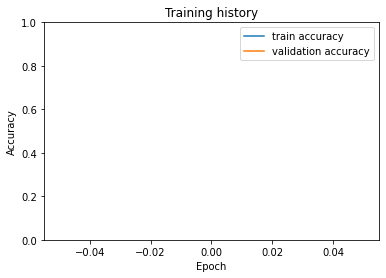

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Prepare model submission

This code below is all for performing the inference on the test set and creating the submission file. In future works it would be better for me to make tokenize_text a global function then call from within NewsDataset that way I can use same function for training, validation, and testing. Currently I have copied pasted the tokenize_text from my NewsDataset. (These should be linked incase I make changes)

In [ ]:
def tokenize_text(text):
  encoding = tokenizer.encode_plus(
                  text, 
                  add_special_tokens = True,
                  max_length = MAX_LEN,
                  return_token_type_ids = False, 
                  padding = 'max_length', # True, 'longest','max_length'
                  return_attention_mask = True,
                  return_tensors = 'pt',
                  truncation = True
      )
  return encoding

In [ ]:
input_test_data = []

# Combine title and text and then clean it
x_test_full['text'] = x_test_full['title'] + " " + x_test_full['text']
x_test_full['text'] = x_test_full['text'].apply(lambda x: clean_text_data(x))

for txt in x_test_full['text']:
  input_test_data.append(tokenize_text(txt))

In [ ]:
#model = FakeNewsClassifier(2)
#model.load_state_dict(torch.load('best_model_state.bin'))
#model = model.to(device)

In [ ]:
test_data = x_test_full # Grab the text only for the prediction

total = len(test_data)
model.eval()

submit = [('id','is_fake')]
with torch.no_grad():
    for ind,x in enumerate(input_test_data):

      input_ids = x["input_ids"].to(device)
      attention_mask = x["attention_mask"].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _ , preds = torch.max(outputs, dim=1) # tensor([max_values], [indices_of_maxes])

      submit.append((int(x_test_full['id'][ind]), int(preds)))

In [ ]:
with open('SimpleBERT_Submission.csv','w') as out:
    csv_out=csv.writer(out)
    for row in submit:
      csv_out.writerow( [row[0], row[1]] )